<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250730/%E5%B7%A1%E5%9B%9E%E3%82%BB%E3%83%BC%E3%83%AB%E3%82%B9%E3%83%9E%E3%83%B3%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
# インストール
!pip install mip
!pip install japanize-matplotlib

#巡回路問題 (巡回セールスマン問題)

この講義では数理計画法における最も有名で研究されている組合せ最適化問題の一つである**巡回セールスマン問題 (Traveling Salesperson Problem - TSP)** について学びます。
巡回セールスマン問題（TSP）は、与えられた都市のリストと、各都市間の移動コスト（距離、時間、費用など）が分かっている場合に、
全ての都市をちょうど一度ずつ巡り、
最終的に出発した都市に戻ってくるような最短の経路
（巡回路またはツアー）を求める問題です。




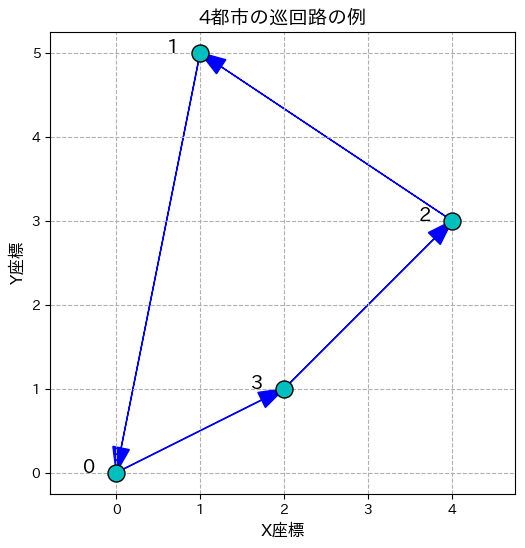

In [ ]:
#@title 巡回路の例
import matplotlib.pyplot as plt
import japanize_matplotlib # ← 日本語表示のためにインポート

# --- データ定義 ---
# 1. 都市の座標
cities_coords = {
    0: (0, 0),
    1: (1, 5),
    2: (4, 3),
    3: (2, 1)
}

# 2. 表示する巡回路
tour = [0, 3, 2, 1, 0]

# --- 描画処理 ---
plt.figure(figsize=(6, 6))

# 1. 都市の点をプロット
for city_id, (x, y) in cities_coords.items():
    plt.scatter(x, y, s=150, c='c', ec='black', zorder=2)
    # 都市番号のラベルを追加
    plt.text(x - 0.4, y , str(city_id), fontsize=14, zorder=3)

# 2. 巡回路の矢印をプロット
for i in range(len(tour) - 1):
    start_city = tour[i]
    end_city = tour[i+1]

    start_pos = cities_coords[start_city]
    end_pos = cities_coords[end_city]

    # 矢印を描画
    plt.arrow(start_pos[0], start_pos[1],
              end_pos[0] - start_pos[0], end_pos[1] - start_pos[1],
              head_width=0.2, length_includes_head=True,
              color='blue', zorder=1, ls='-')

# グラフの装飾
plt.title('4都市の巡回路の例', fontsize=14)
plt.xlabel('X座標', fontsize=12)
plt.ylabel('Y座標', fontsize=12)
plt.grid(True, linestyle='--')
plt.axis('equal') # X軸とY軸のスケールを合わせる
plt.show()

**問題の主要な要素:**
* **都市 (Cities/Nodes):** 訪問すべき地点の集合。
* **移動コスト (Travel Costs/Distances):** 任意の2都市間を移動するのにかかるコスト。コストが方向によって異なる場合（例：$i \to j$ のコストと $j \to i$ のコストが違う）は**非対称TSP (Asymmetric TSP)**、方向によらない場合は**対称TSP (Symmetric TSP)** と呼ばれます。ただし定式化はどちらも同じである。
* **巡回路 (Tour/Hamiltonian Cycle):** 全ての都市をちょうど一度ずつ訪問し、出発点に戻る閉じた路。

**目的:** 総移動コストが最小となる巡回路を見つけること。

TSPは、その単純な定義にもかかわらず、都市数が増えると最適な解を見つけるのが非常に困難になる**NP困難**な問題として知られています。しかし、物流、製造、電子回路設計など、多岐にわたる分野で実用的な応用が存在するため、効率的な解法や近似解法の研究が盛んに行われています。

**実社会での応用例:**
* **物流・配送計画:** 複数の配送先を巡回するトラックの最短ルート計画。
* **回路基板の製造:** プリント基板上でドリルで穴を開ける際、ドリルヘッドの移動距離を最小化する順序の決定。
* **ゲノム解析:** DNA断片の順序付け。
* **観光ルート計画:** 複数の観光地を効率よく巡るルートの作成。

この講義では、比較的小規模なTSPに対して、整数計画法を用いた厳密解法（特にMTZ法として知られる部分巡回路除去制約を用いた定式化）を学びます。

##定式化

ここでは、
移動距離が方向によらない対称TSPを考え、都市間の距離に基づいて総移動距離を最小化する巡回路を見つける問題を定式化します。


#### 決定変数

TSPを整数計画問題として定式化するために、以下の変数を定義します。
* $x_{ij} \in \{0, 1\}$: 都市 $i$ から都市 $j$ へ直接移動する場合に1、そうでない場合に0をとるバイナリ変数 ($i \neq j$)。

* $u_i$: 都市 $i$ が巡回路の中で何番目に訪問されるか（順序）を示す変数。
特に、デポの順序は1番目とする。
$i \in \{1, 2, 3\}$ （都市0をデポとする）。

 まず、変数 $x_{ij}$ に巡回路となるよう0か1かを与える条件（制約条件）を考える。

1.  **出次数制約 (Degree-out constraint):** 各都市 $i$ からは、必ず1つの他の都市へ出発しなければなりません。
例えば、都市 0 に注目すると
$$
x_{01} + x_{02} + x_{03} = 1
$$
でなくてはならない。（下の図を参照）

 同様に、都市 1,2,3 それぞれで、
$$
x_{10} + x_{12} + x_{13} = 1, \\
x_{20} + x_{21} + x_{23} = 1, \\
x_{30} + x_{31} + x_{32} = 1
$$
でなければならない。
上の4本の数式は、以下のようにまとめて書くことができる。

$$\sum_{j=0, j \neq i}^{3} x_{ij} = 1 \quad \forall i \in \{0, 1, 2, 3\}$$

2.  **入次数制約 (Degree-in constraint):** 各都市 $j$ へは、必ず1つの他の都市から到着しなければなりません。
$$\sum_{i=0, i \neq j}^{3} x_{ij} = 1 \quad \forall j \in \{0, 1, 2, 3\}$$


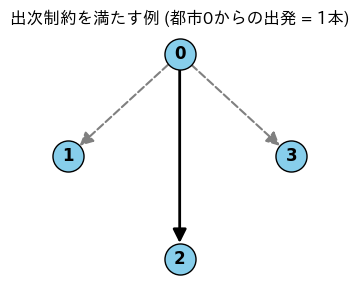

In [ ]:
#@title 出次数制約の図
import matplotlib.pyplot as plt
import japanize_matplotlib # ← 日本語表示のためにインポート
import networkx as nx

# --- グラフの基本設定 ---
# 都市のノードと座標
nodes = [0, 1, 2, 3]
pos = {0: (0, 1), 1: (-1, 0), 2: (0, -1), 3: (1, 0)}
node_size = 500 # ノードサイズをここで定義

# --- グラフオブジェクトの作成 ---
G = nx.DiGraph()
G.add_nodes_from(nodes)

# 実際に選択された辺（実線）
selected_edge = (0, 2)
G.add_edge(*selected_edge)

# 選択されなかった可能性のある辺（破線）
potential_edges = [(0, 1), (0, 3)]
G.add_edges_from(potential_edges)

# --- 描画 ---
plt.figure(figsize=(3, 3))
ax = plt.gca()

# ノードを描画
nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_size=node_size,
    node_color="skyblue",
    edgecolors="black"
)
# ノードラベルを描画
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_weight="bold")

# 選択された辺（実線）を描画
nx.draw_networkx_edges(
    G, pos, ax=ax,
    edgelist=[selected_edge],
    node_size=node_size,  # <<< 矢印が隠れないようにノードサイズを指定
    width=2.0,
    arrowsize=20,
    edge_color="black"
)

# 選択されなかった辺（破線）を描画
nx.draw_networkx_edges(
    G, pos, ax=ax,
    edgelist=potential_edges,
    node_size=node_size,  # <<< 矢印が隠れないようにノードサイズを指定
    width=1.5,
    arrowsize=20,
    edge_color="gray",
    style="dashed"
)

ax.set_title("出次制約を満たす例 (都市0からの出発 = 1本)", fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.show()


3.  **部分巡回路除去制約 (Subtour Elimination Constraints - SECs):**
上記の制約だけでは、全体の巡回路ではなく、複数の小さな独立したループ（部分巡回路）が形成される可能性がある(下の図を参照せよ)。
これを防ぐためには追加の制約が必要です。
ここでは、Miller-Tucker-Zemlin (MTZ) formulation に基づく制約を用います。

 都市 $i$ に対応した補助変数 $u_i$ を導入し、
この変数で都市 $i \in \{0, 1, 2, 3\}$ の訪問順序を表すとする。
特に都市0をデポ（出発点・帰着点、順序1）と考え
$$
u_0=1
$$
とし、
デポ以外の都市で$u_i$ では
$$2 \le u_i \le 4, \quad i \in \{1,2,3\}$$
の整数値を持つものとする。

 このとき次の制約条件
$$u_i - u_j + 4 \cdot x_{ij} \le 4-1 \quad \forall i, j \in \{1, 2, 3\}, i \neq j$$
を追加する。$4$ は都市数である。

 この数式は、もし $x_{ij}=1$ (つまりデポ以外の都市 $i$ からデポ以外の都市 $j$ へ移動する) ならば、
$$u_i +1 \le u_j$$
となるように制約し、$u_i$ が1増加する制約条件となり、
全体として考えると訪問順序となるよう制約する働きがある。

 ちなみに、$x_{ij}=0$ の場合は
$$
u_i - u_j \le 4-1 = 3
$$
となることから、常に満たされる冗長な制約条件となる。

 結果として、部分巡回路の形成を防ぎます。

4.  **変数型制約:**
$$x_{ij} \in \{0, 1\} \quad \forall i, j \in \{0, 1, 2, 3\}, i \neq j$$   $$ 2 \le u_i \le 4 \text{ となる整数変数}$$


##次数の制約のみの場合

上で示した次数制約のみでは、以下のような部分巡回となる解が得られてしまう。

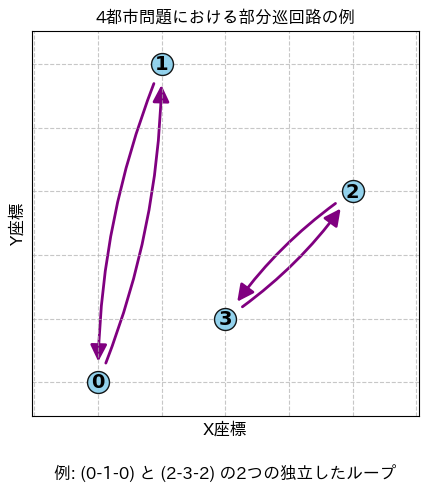

In [ ]:
#@title 部分巡回路の図
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import networkx as nx # NetworkXをインポート

# 都市のデータ (TSP基本例と同じ)
cities_coords_subtour = {
    0: (0, 0),
    1: (1, 5),
    2: (4, 3),
    3: (2, 1)
}
city_names_subtour = list(cities_coords_subtour.keys())
num_cities_subtour = len(city_names_subtour)
coords_array_subtour = np.array([cities_coords_subtour[c] for c in city_names_subtour])

# 部分巡回路を構成するアークの例
# 例: (0-1-0) と (2-3-2) の2つのループ
subtour_arcs = [
    (0, 1), (1, 0), # ループ1
    (2, 3), (3, 2)  # ループ2
]

# 有向グラフを作成
G_subtour = nx.DiGraph()
G_subtour.add_nodes_from(city_names_subtour)
for u, v in subtour_arcs:
    G_subtour.add_edge(u, v)

# ノードの配置
pos_subtour = {name: coord for name, coord in cities_coords_subtour.items()}

# グラフの描画設定
plt.figure(figsize=(5, 5))
node_draw_size_subtour = 250 # ノードの描画サイズ

# ノードを描画
nx.draw_networkx_nodes(G_subtour, pos_subtour, node_size=node_draw_size_subtour,
                       node_color='skyblue', alpha=0.9, edgecolors="black", linewidths=1)
nx.draw_networkx_labels(G_subtour, pos_subtour, font_size=14, font_weight='bold', font_color='black')


# エッジ（アーク）を描画
nx.draw_networkx_edges(
    G_subtour,
    pos_subtour,
    edgelist=subtour_arcs,
    width=2.0,         # 線の太さ
    arrowstyle='-|> ', # 矢印のスタイル
    arrowsize=25,      # 矢印の先のサイズ
    edge_color='purple',
    connectionstyle='arc3,rad=0.1', # 線を少しカーブさせる
    node_size=node_draw_size_subtour, # ノードサイズをエッジ描画に伝える
    min_source_margin=15, # ソースノードからのマージン
    min_target_margin=15  # ターゲットノードへのマージン
)

plt.xlabel("X座標", fontsize=12)
plt.ylabel("Y座標", fontsize=12)
plt.title(f"{num_cities_subtour}都市問題における部分巡回路の例", fontsize=12)
plt.text(2, -1.5, "例: (0-1-0) と (2-3-2) の2つの独立したループ",
         horizontalalignment='center', fontsize=12) # color='darkred')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.show()

なお、上の例に部分巡回路制約が追加されると、
$$
x_{23}=1
$$
$$
x_{32}=1
$$
より、
$$
u_2 + 1 \le u_3
$$
$$
u_3 + 1 \le u_2
$$
となる。これを満たすように $u_2,u_3$ に整数を付与することができないことから、
結果的に上記ように部分巡回を構成する値を変数$x_{ij}$が取らないことが保証される。



#### 目的関数

$x_{ij}$ は、巡回路を構成する場合に1となりそれ以外は0となることから、
巡回路の総距離は以下のようになる。
$$
\text{Minimize} \quad Z = \sum_{i=0}^{3} \sum_{j=0, j \neq i}^{3} c_{ij} x_{ij}$$
ここで、$c_{ij}$ は都市 $i$ から都市 $j$ への移動コスト（距離）です。



---
## 数理モデル（MTZ法による数式表記）

上記をまとめると、MTZ法を用いたTSPの数理モデルは以下のようになります。
$N$ を都市の総数とし、都市の集合を $V = \{0, 1, \dots, N-1\}$ とします。都市0をデポ（巡回の開始点かつ終了点）とします。

**パラメータ:**
* $c_{ij}$: 都市 $i$ から都市 $j$ への移動コスト（距離）。

**決定変数:**
* $x_{ij} \in \{0,1\}$: 都市 $i$ から都市 $j$ へ直接移動する場合に1、それ以外は0 ($i,j \in V, i \neq j$)。
* $u_i$: 都市 $i \in V \setminus \{0\}$ の訪問順序を示す整数変数。
デポ0の順序は1番目とみなし、$u_0=1$ とし、また
$u_i \in [2, N]$ for $i \in V \setminus \{0\}$ とします。

**目的関数:**
$$\text{Minimize} \quad \sum_{i \in V} \sum_{j \in V, j \neq i} c_{ij} x_{ij}$$

**制約条件:**
$$\sum_{j \in V, j \neq i} x_{ij} = 1 \quad \forall i \in V \quad \text{(各都市から一度出発)}$$$$\sum_{i \in V, i \neq j} x_{ij} = 1 \quad \forall j \in V \quad \text{(各都市へ一度到着)}$$$$u_i - u_j + N \cdot x_{ij} \le N-1 \quad \forall i, j \in V \setminus \{0\}, i \neq j \quad \text{(MTZ部分巡回路除去)}$$$$2 \le u_i \le N \quad \forall i \in V \setminus \{0\} \quad \text{(順序変数の範囲)}$$$$x_{ij} \in \{0, 1\} \quad \forall i,j \in V, i \neq j$$

*注意: MTZ制約は、比較的小さなインスタンスには有効ですが、都市数が多くなるとモデルの線形計画緩和の質が悪くなり、解くのに時間がかかることがある。
Dantzig-Fulkerson-Johnson formulation と呼ばれる別の数理モデルも提案されている*



---
---
##基本例の問題設定

セールスマンが4つの都市 (0, 1, 2, 3) を訪問する必要があるとします。都市0を出発点とし、他の全ての都市を一度ずつ訪問し、最後に都市0に戻ってくるものとします。各都市の座標が与えられており、都市間の移動コストはユークリッド距離とします。

* **都市の座標:**
    * 都市0: (0, 0) - デポ（出発・帰着点）
    * 都市1: (1, 5)
    * 都市2: (4, 3)
    * 都市3: (2, 1)

#### 都市の配置図と距離行列 (Python)

まず、これらの都市がどのように配置されているかを図で確認し、
都市間の距離行列をユークリッド距離として計算します。

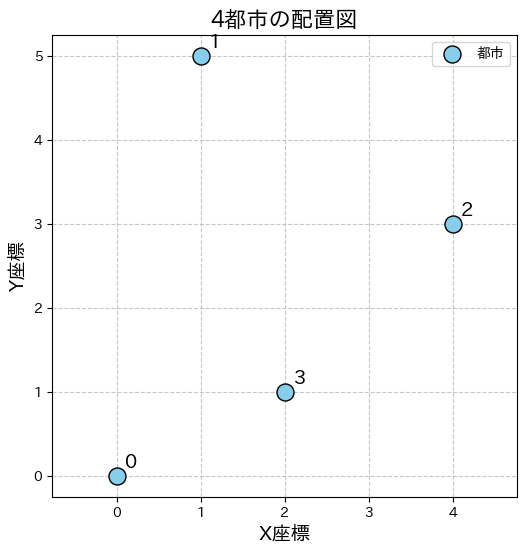

In [ ]:
#@title 図示
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import math
import pandas as pd # DataFrame表示用

# 都市のデータ
cities_coords = {
    0: (0, 0),
    1: (1, 5),
    2: (4, 3),
    3: (2, 1)
}
city_names = list(cities_coords.keys())
num_cities = len(city_names)
coords_array = np.array([cities_coords[c] for c in city_names])

# 都市間の距離を計算する関数
def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# 距離行列の作成
dist_matrix = np.zeros((num_cities, num_cities))
costs_for_mip = {} # MIPモデル用のコスト辞書
for i in range(num_cities):
    for j in range(num_cities):
        if i == j:
            dist_matrix[i,j] = 0
            costs_for_mip[i,j] = 0 # あるいは大きな値
        else:
            dist_val = calculate_distance(cities_coords[i], cities_coords[j])
            dist_matrix[i,j] = dist_val
            costs_for_mip[i,j] = dist_val


#print("都市の座標:")
#for i, coord in cities_coords.items():
#    print(f"都市 {i}: {coord}")

#print("\n距離行列 (c_ij):")
#dist_df = pd.DataFrame(dist_matrix, index=city_names, columns=city_names)
#print(dist_df.round(3))


# 都市の配置をプロット
plt.figure(figsize=(6, 6))
plt.scatter(coords_array[:, 0], coords_array[:, 1], marker='o', s=150, color='skyblue', edgecolors='black', zorder=5, label="都市")
for i, name in enumerate(city_names):
    plt.text(coords_array[i, 0] + 0.1, coords_array[i, 1] + 0.1, str(name), fontsize=14, color='black')

plt.xlabel("X座標", fontsize=14)
plt.ylabel("Y座標", fontsize=14)
plt.title(f"{num_cities}都市の配置図", fontsize=16)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.show()

##Python MIP を用いた実装例

この4都市の例題を `python-mip` を用いて最適化する。

都市の座標から、都市間の距離を計算する。
距離はユークリッド距離とする。

2点$c_1,c_2$ の座標を
$$
c_1 = (a_1, b_1), \quad c_2=(a_2,b_2)
$$
としたとき、
ユークリッド距離は以下のように計算される。
$$
 \sqrt{ (a_1-a_2)^2 + (b_1-b_2)^2 }
$$

In [ ]:
from mip import Model, xsum, minimize, BINARY, INTEGER, OptimizationStatus
import math
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import pandas as pd # 距離行列表示用

# --- データ定義 ---
cities_coords_mip = {
    0: (0, 0), 1: (1, 5), 2: (4, 3), 3: (2, 1)
}

city_indices_mip = list(cities_coords_mip.keys())
num_cities_mip = len(city_indices_mip)

# 距離行列の計算
costs_mip = {} # (i,j) -> cost
for i in city_indices_mip:
    for j in city_indices_mip:
        if i == j:
            continue # 自分自身へのコストは不要
        coord1 = cities_coords_mip[i]
        coord2 = cities_coords_mip[j]
        # 座標の値からユークリッド距離を計算
        costs_mip[i,j] = math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)


# --- モデル作成 ---
model_tsp = Model("TSP_MTZ")

# 決定変数 x_ij: 都市iから都市jへ移動するか
x = {(i, j): model_tsp.add_var(var_type=BINARY, name=f"x_{i}_{j}")
     for i in city_indices_mip for j in city_indices_mip if i != j}

# 決定変数 u_i: 都市iの訪問順序 (デポ0以外の都市用)
# u_i の範囲は 2 から N (Nは都市数)
u = {i: model_tsp.add_var(var_type=INTEGER, lb=2, ub=num_cities_mip, name=f"u_{i}")
     for i in city_indices_mip if i != 0} # デポ0は除く

# 目的関数: 総移動距離の最小化
model_tsp.objective = minimize(xsum(costs_mip[i,j] * x[i,j]
                                   for i in city_indices_mip for j in city_indices_mip if i != j))

# 制約条件
# 1. 各都市から必ず1つの都市へ出発
for i in city_indices_mip:
    model_tsp += xsum(x[i,j] for j in city_indices_mip if i != j) == 1, f"leave_city_{i}"

# 2. 各都市へ必ず1つの都市から到着
for j in city_indices_mip:
    model_tsp += xsum(x[i,j] for i in city_indices_mip if i != j) == 1, f"enter_city_{j}"

# 3. MTZ 部分巡回路除去制約 (デポ0以外の都市間 i,j ∈ {1, ..., N-1})
if num_cities_mip > 2: # 3都市以上でMTZ制約が必要 (デポ以外に2都市以上)
    for i in city_indices_mip:
        if i == 0: continue # デポはu変数の対象外
        for j in city_indices_mip:
            if j == 0 or i == j: continue # デポまたは同じ都市はスキップ
            # u_i - u_j + N * x_ij <= N - 1  (Nは総都市数)
            model_tsp += u[i] - u[j] + num_cities_mip * x[i, j] <= num_cities_mip - 1, f"MTZ_{i}_{j}"

# モデルの最適化
status = model_tsp.optimize(max_seconds=60) # 時間制限を設ける場合

# --- 結果の表示 ---
optimal_tour_list = []
optimal_distance_val = 0.0

if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    optimal_distance_val = model_tsp.objective_value
    print(f"解が見つかりました。総移動距離: {optimal_distance_val:.3f}")

    # 巡回路の復元
    current_city = 0 # デポからスタート
    optimal_tour_list.append(current_city)
    visited_count = 1

    while visited_count < num_cities_mip:
        found_next = False
        for j_city in city_indices_mip:
            if j_city != current_city and (current_city, j_city) in x and x[current_city, j_city].x >= 0.99:
                if j_city not in optimal_tour_list: # まだ訪問していなければ追加
                    optimal_tour_list.append(j_city)
                    current_city = j_city
                    visited_count += 1
                    found_next = True
                    break
        if not found_next: # 次の都市が見つからない場合 (エラーまたは部分解)
            print(f"警告: 巡回路の復元に問題が発生しました。部分ツアー: {optimal_tour_list}")
            break

    if len(optimal_tour_list) == num_cities_mip: # 全都市を訪問完了
        optimal_tour_list.append(0) # デポに戻る
        print(f"巡回路: {optimal_tour_list}")
    else:
        print(f"注意: 完全な巡回路が形成されていません。復元されたツアー: {optimal_tour_list}")

elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました（時間切れまたは解なし）。ステータス: {status}")


解が見つかりました。総移動距離: 13.769
巡回路: [0, 3, 2, 1, 0]


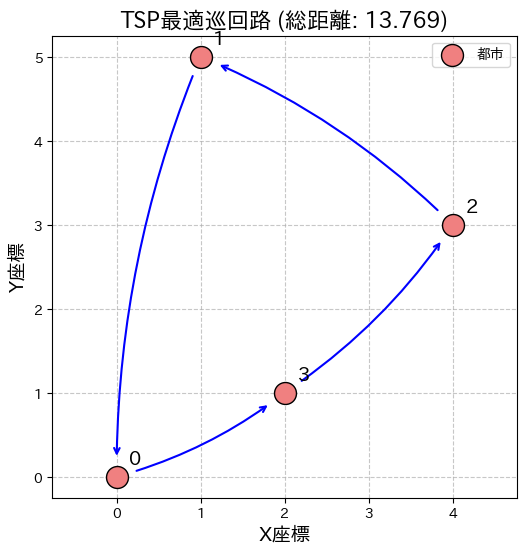

In [ ]:
#@title 結果の図示
plt.figure(figsize=(6, 6))
coords_plot_array_mip = np.array([cities_coords_mip[c] for c in city_indices_mip]) # 再度定義
plt.scatter(coords_plot_array_mip[:, 0], coords_plot_array_mip[:, 1], marker='o', s=250, color='lightcoral', edgecolors='black', zorder=5, label="都市")
for i, name in enumerate(city_indices_mip):
    plt.text(coords_plot_array_mip[i, 0] + 0.15, coords_plot_array_mip[i, 1] + 0.15, str(name), fontsize=14, color='black')

if optimal_tour_list and len(optimal_tour_list) == num_cities_mip + 1 and optimal_tour_list[0] == optimal_tour_list[-1]:
    # 巡回路の線を描画
    tour_coords = np.array([cities_coords_mip[city_idx] for city_idx in optimal_tour_list])
    # plt.plot(tour_coords[:,0], tour_coords[:,1], 'bo-', alpha=0.7, linewidth=2, markersize=7, zorder=3, label="最適巡回路")
    # 矢印を追加
    for k_idx in range(len(optimal_tour_list) - 1):
        start_node_coords = cities_coords_mip[optimal_tour_list[k_idx]]
        end_node_coords = cities_coords_mip[optimal_tour_list[k_idx+1]]
        plt.annotate("",
                     xy=end_node_coords, xycoords='data',
                     xytext=start_node_coords, textcoords='data',
                     arrowprops=dict(arrowstyle="->", color="blue", lw=1.5,
                                     shrinkA=15, shrinkB=15, # ノードに隠れないように調整
                                     patchA=None, patchB=None,
                                     connectionstyle="arc3,rad=0.1"),
                     zorder=2
                    )
    plt.legend(loc='upper right')
else:
    print("巡回路が正しく形成されていないため、経路は描画されません。")

plt.xlabel("X座標", fontsize=14)
plt.ylabel("Y座標", fontsize=14)
if optimal_distance_val > 0:
    plt.title(f"TSP最適巡回路 (総距離: {optimal_distance_val:.3f})", fontsize=16)
else:
    plt.title(f"TSP巡回路 (解の状態: {status})", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.show()

###結果の解釈

上記のコードを実行すると、以下の情報が得られます。
* **総移動距離:** 最小化された目的関数の値。これが、全ての都市を巡回するための最短距離です。
* **巡回路:** 訪問する都市の順序。
`[0, 3, 2, 1, 0]` と表示されていることから、
都市0から出発し、都市3、都市2、都市1の順に訪問し、
最後に都市0に戻ることを意味する。
* **結果の図示:** 地図上に都市がプロットされ、
最適解として得られた巡回路が線で結ばれて表示されている。

MTZ法による定式化は、都市数が少ない場合には有効ですが、都市数が20～30を超えてくると、計算時間が急激に増加する傾向にあります。



---
### モデルの改善に関する簡単な視点

TSPはNP困難な問題であり、厳密解を求めるのは大規模なインスタンスでは非常に時間がかかります。
* **より強力な部分巡回路除去制約:** Dantzig-Fulkerson-Johnson (DFJ) の定式化では、指数関数的な数の制約を必要としますが、より質の高い解が得られやすいです。これらは通常、**遅延制約生成 (cutting plane method / branch-and-cut)** と呼ばれる手法で、必要な制約を逐次的に追加しながら解かれます。
* **ヒューリスティクス・近似アルゴリズム:** 大規模問題に対し、最適性は保証されないが良い解を短時間で見つける手法。
    * **最近傍法 (Nearest Neighbor):** 現在地から最も近い未訪問都市へ移動。
    * **2-opt, 3-opt等の局所探索法:** 現在の巡回路の一部を組み替えて改善。
    * **メタヒューリスティクス:** 焼きなまし法(SA)、遺伝的アルゴリズム(GA)等。
* **TSPの亜種:** CVRP (車両ルーティング問題)、TSPTW (時間枠付きTSP) 等。




---
#演習問題


##演習問題1

基本例の都市2の座標を (4,3) から (5,0) に変更し、都市3の座標を (2,1) から (3,4) に変更した場合、最適な巡回路の総移動距離を求めよ。


##演習問題2

基本例の4都市（0, 1, 2, 3）に、新たに都市4（座標 (3,6)）を追加します。この5都市（デポ0を含む）の最適な巡回路を求め、
その総移動距離を解答せよ。


##演習問題3

基本例の4都市問題において、何らかの理由で都市1と都市2の間の直接移動が禁止されたとします。この制約を追加した場合、最適な総移動距離を解答せよ。


##演習問題4

基本例の4都市問題において、都市1を訪問した後（直接でなくてもよい）、必ず都市3を訪問しなければならないという制約を追加せよ。
この制約下で最適な巡回路を求め、総移動距離を解答せよ。


##演習問題5

基本例の都市間移動コストが、方向によって異なるとします（非対称コスト）。以下のコスト行列 $c_{ij}$（都市$i$から都市$j$へのコスト）を用いて、最適な巡回路の総移動コストを解答せよ。

$c = \begin{pmatrix} \infty & 10 & 15 & 20 \\ 5 & \infty & 9 & 10 \\ 6 & 13 & \infty & 12 \\ 8 & 8 & 9 & \infty \end{pmatrix}$
